In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [5]:
# Download Dataset
path = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Dataset path:", path)

train_dir = os.path.join(path, "training_set/training_set")
test_dir = os.path.join(path, "test_set/test_set")


Using Colab cache for faster access to the 'cat-and-dog' dataset.
Dataset path: /kaggle/input/cat-and-dog


In [6]:
img_size = (224, 224)   # ResNet expects 224x224 input
batch_size = 32

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [9]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,      # drop original FC layers
    input_shape=(224, 224, 3)
)

# Freeze base model to use pretrained features
base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")   # binary classification
])

In [11]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 145s 654ms/step - accuracy: 0.9348 - loss: 0.1470 - val_accuracy: 0.9669 - val_loss: 0.0903
Epoch 2/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 101s 505ms/step - accuracy: 0.9707 - loss: 0.0817 - val_accuracy: 0.9763 - val_loss: 0.0601
Epoch 3/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 122s 607ms/step - accuracy: 0.9798 - loss: 0.0487 - val_accuracy: 0.9875 - val_loss: 0.0335
Epoch 4/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 121s 500ms/step - accuracy: 0.9801 - loss: 0.0465 - val_accuracy: 0.9838 - val_loss: 0.0444
Epoch 5/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 144s 513ms/step - accuracy: 0.9831 - loss: 0.0434 - val_accuracy: 0.9800 - val_loss: 0.0467


In [13]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.9893 - loss: 0.0607
Test Accuracy: 99.01%


Text(0.5, 1.0, 'Accuracy')

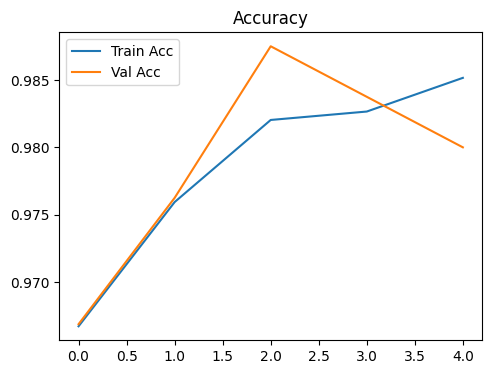

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

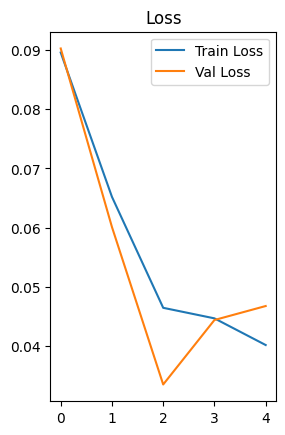

In [15]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [16]:
cat_test_path = os.path.join(test_dir, "cats")
dog_test_path = os.path.join(test_dir, "dogs")

In [17]:
from keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # IMPORTANT: match ResNet preprocessing

    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    print(f"Prediction: {label} ({prediction:.4f})")

predict_image(os.path.join(cat_test_path, os.listdir(cat_test_path)[0]))

predict_image(os.path.join(dog_test_path, os.listdir(dog_test_path)[1]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Cat (0.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: Dog (0.8907)
